In [2]:
import os
from argparse import Namespace
from pathlib import Path

import pytorch_lightning as pl
import torch
from torch.utils.data import Subset
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm import trange

from dpsnn import SplitNN, ConvAttackModel, plot_images, AttackDataset

In [3]:
project_root = Path.cwd().resolve().parents[1]

---
# Post-training noise

In this experiment,
we apply noise to the intermediate tensor _after_ training.
This is not technically a differentially private mechanism.
This defence can be applied post-hoc to any model,
as no specialised training process is required.

---

## Load target model
Load model a model trained without noise

In [4]:
classifiers_path = project_root / "models" / "classifiers"
os.listdir(classifiers_path)

['mnist_00noise_100nopeek_epoch=00.ckpt',
 'mnist_02noise_00nopeek_epoch=07.ckpt',
 'mnist_10noise_00nopeek_epoch=08.ckpt',
 'mnist_00noise_50nopeek_epoch=09.ckpt',
 'mnist_01noise_00nopeek_epoch=06.ckpt',
 'mnist_05noise_00nopeek_epoch=08.ckpt',
 'mnist_00noise_00nopeek_epoch=06.ckpt',
 'mnist_00noise_01nopeek_epoch=09.ckpt',
 'mnist_00noise_10nopeek_epoch=09.ckpt',
 '.gitkeep',
 'mnist_00noise_05nopeek_epoch=08.ckpt']

In [23]:
def _load_classifier(model_name, noise):
    checkpoint = torch.load(classifiers_path / model_name)
    hparams = checkpoint["hyper_parameters"]

    target_model = SplitNN(hparams)
    target_model.load_state_dict(checkpoint["state_dict"])
    target_model.prepare_data()
    target_model.set_noise(noise)
    target_model.eval()
    target_model.freeze()

    return target_model

In [24]:
target_model00 = _load_classifier("mnist_00noise_00nopeek_epoch=06.ckpt", 0.0)
target_model01 = _load_classifier("mnist_00noise_00nopeek_epoch=06.ckpt", 0.1)
target_model05 = _load_classifier("mnist_00noise_00nopeek_epoch=06.ckpt", 0.5)
target_model10 = _load_classifier("mnist_00noise_00nopeek_epoch=06.ckpt", 1.0)

target_models = [target_model00, target_model01, target_model05, target_model10]

## Confirm target model performance

In [25]:
target_trainer = pl.Trainer(gpus=None, overfit_batches=0.5)  # use half of validation data

for target_model in target_models:
    target_trainer.test(target_model, target_model.val_dataloader())

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_loss': tensor(1.4697),
 'test_acc': tensor(99.3640),
 'test_loss': tensor(1.4697)}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_loss': tensor(1.4698),
 'test_acc': tensor(99.3640),
 'test_loss': tensor(1.4698)}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_loss': tensor(1.4712),
 'test_acc': tensor(99.2688),
 'test_loss': tensor(1.4712)}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_loss': tensor(1.4779),
 'test_acc': tensor(98.7780),
 'test_loss': tensor(1.4779)}
--------------------------------------------------------------------------------



---
# Attack models

## Get validation set for attackers

- Classifier is trained on first `40'000` MNIST "train" images
- Attacker is trained on `40'000-45'000` first MNIST "train" images
- Validate attacker on MNIST "train" images `45'000-50'000`

In [10]:
transform = transforms.Compose(
        [
            transforms.ToTensor(),
            # PyTorch examples; https://github.com/pytorch/examples/blob/master/mnist/main.py
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
)

attack_val_dataset = torch.utils.data.Subset(
        MNIST(project_root / "data", download=True, train=True, transform=transform),
        range(45_000, 50_000),
)

## Load attackers

In [11]:
attackers_dir = project_root / "models" / "attackers"
os.listdir(attackers_dir)

['mnist_attacker_model<mnist_00noise_00nopeek.ckpt>_set0.ckpt',
 'mnist_attacker_model<mnist_00noise_00nopeek>_set01noise.ckpt',
 'mnist_attacker_model<mnist_00noise_01nopeek.ckpt',
 'mnist_attacker_model<mnist_05noise_00nopeek.ckpt',
 'mnist_attacker_model<mnist_00noise_05nopeek.ckpt',
 'mnist_attacker_model<mnist_10noise_00nopeek.ckpt',
 'mnist_attacker_model<mnist_00noise_00nopeek>_set05noise.ckpt',
 'mnist_attacker_model<mnist_00noise_00nopeek.ckpt',
 'mnist_attacker_model<mnist_01noise_00nopeek.ckpt',
 'mnist_attacker_model<mnist_00noise_00nopeek>_set10noise.ckpt',
 '.gitkeep',
 'mnist_attacker_model<mnist_00noise_10nopeek.ckpt']

In [14]:
def _load_attacker(attacker_name):
    attack_model = ConvAttackModel({})
    attack_model.load_state_dict(torch.load(attackers_dir / attacker_name))
    attack_model.eval()

    return attack_model

In [15]:
attack_model00 = _load_attacker("mnist_attacker_model<mnist_00noise_00nopeek.ckpt")
attack_model01 = _load_attacker("mnist_attacker_model<mnist_00noise_00nopeek>_set01noise.ckpt")
attack_model05 = _load_attacker("mnist_attacker_model<mnist_00noise_00nopeek>_set05noise.ckpt")
attack_model10 = _load_attacker("mnist_attacker_model<mnist_00noise_00nopeek>_set10noise.ckpt")

attack_models = [attack_model00, attack_model01, attack_model05, attack_model10]

---
# 0.0 noise

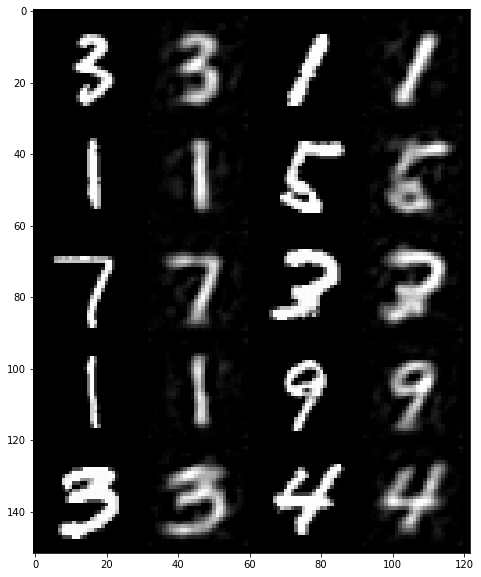

In [26]:
ims = []

for i in range(10):
    image, _ = attack_val_dataset[i]
    with torch.no_grad():
        intermediate = target_model00.encode(image.unsqueeze(0))
        reconstructed = attack_model00(intermediate)

    reconstructed = reconstructed.squeeze(0)
    ims.extend([image, reconstructed])

plot_images(ims, rows=4)

## 0.1 noise

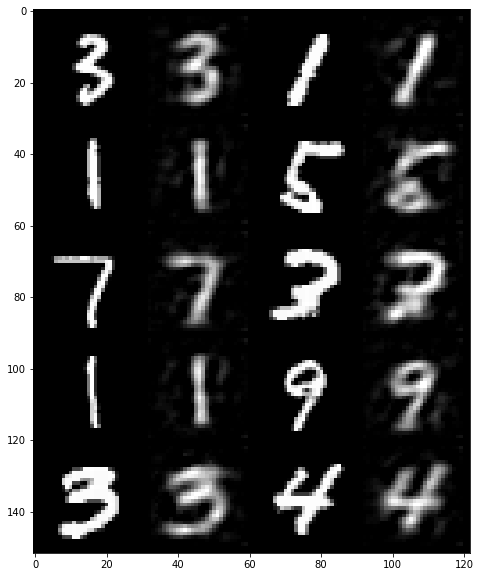

In [27]:
ims = []

for i in range(10):
    image, _ = attack_val_dataset[i]
    with torch.no_grad():
        intermediate = target_model01.encode(image.unsqueeze(0))
        reconstructed = attack_model01(intermediate)

    reconstructed = reconstructed.squeeze(0)
    ims.extend([image, reconstructed])

plot_images(ims, rows=4)

## 0.5 noise

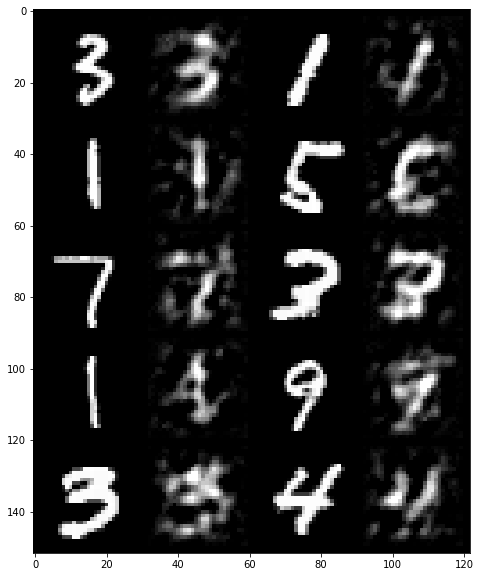

In [28]:
ims = []

for i in range(10):
    image, _ = attack_val_dataset[i]
    with torch.no_grad():
        intermediate = target_model05.encode(image.unsqueeze(0))
        reconstructed = attack_model05(intermediate)

    reconstructed = reconstructed.squeeze(0)
    ims.extend([image, reconstructed])

plot_images(ims, rows=4)

## 1.0 noise

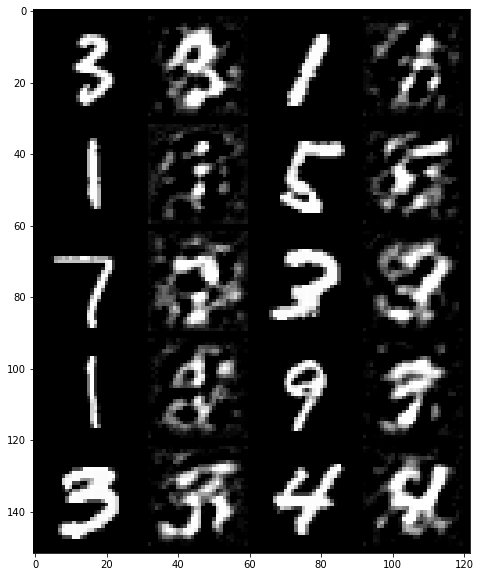

In [29]:
ims = []

for i in range(10):
    image, _ = attack_val_dataset[i]
    with torch.no_grad():
        intermediate = target_model10.encode(image.unsqueeze(0))
        reconstructed = attack_model10(intermediate)

    reconstructed = reconstructed.squeeze(0)
    ims.extend([image, reconstructed])

plot_images(ims, rows=4)

---
## Side-by-side comparison

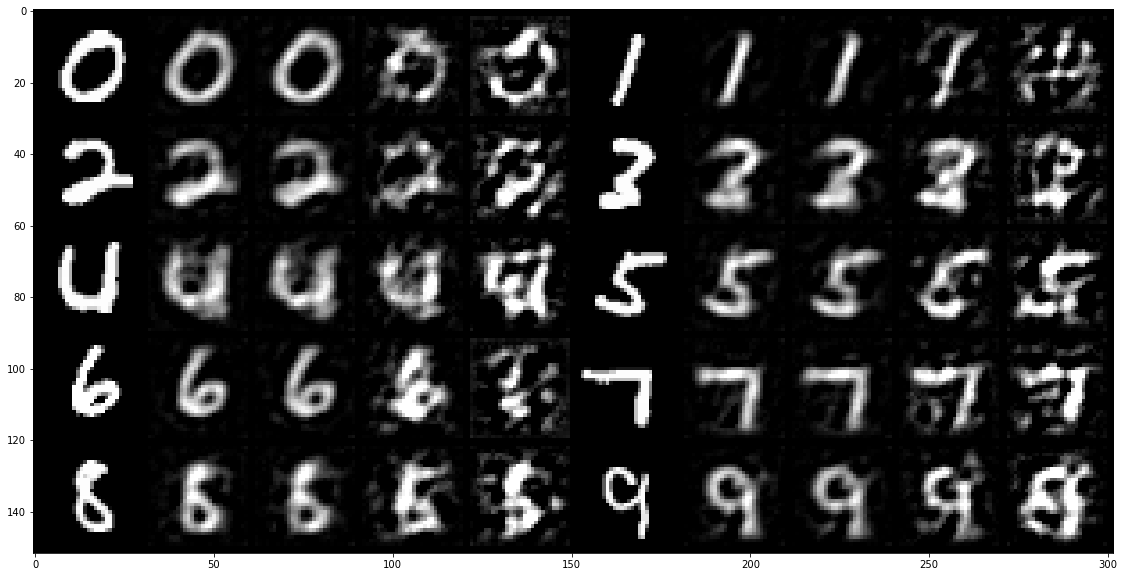

In [32]:
ims = []

label_to_plot = 0
idx = 10

while True:
    image, im_label = attack_val_dataset[idx]
    idx += 1

    if im_label != label_to_plot:
        continue
        
    ims.append(image)

    for target_model, attack_model in zip(target_models, attack_models):
        with torch.no_grad():
            intermediate = target_model.encode(image.unsqueeze(0))
            reconstructed = attack_model(intermediate)

        reconstructed = reconstructed.squeeze(0)
        ims.append(reconstructed)

    label_to_plot += 1
    if label_to_plot == 10:
        break

plot_images(ims, rows=10)#, savepath=project_root / "results" / "figures" / "mnist_post_training_laplacian_dp_attack.png")